# Advanced Physical Modelling

In the previous tutorial, we simply modelled the chemistry of a static cloud for 1 Myr. This is unlikely to meet everybody's modelling needs and UCLCHEM is capable of modelling much more complex environments such as hot cores and shocks. In this tutorial, we model both a hot core and a shock to explore how these models work and to demonstrate the workflow that the UCLCHEM team normally follow.

In [1]:
import uclchem
import pandas as pd
import matplotlib.pyplot as plt

## The Hot Core

### Initial Conditions
UCLCHEM typically starts with the gas in atomic/ionic form with no molecules. However, this clearly is not appropriate when modelling an object such as a hot core. In these objects, the gas is already evolved and there should be molecules in the gas phase as well as ice mantles on the dust. To allow for this, one must provide some initial abundances to the model. There are many ways to do this but we typically chose to run a preliminary model to produce our abundances.

For this case, we will use `uclchem.model.cloud()` to run a model where a cloud of gas collapses from a density of $10^2 cm^{-3}$ to our hot core density of $10^6 cm^{-3}$. During this collapse, chemistry will occur and we can assume the final abundances of this model will be reasonable starting abundances for the hot core. 

In [2]:
# set a parameter dictionary for phase 1 collapse model
param_dict = {
    "switch": 0,#stop at finalTime
    "freefall": 1,#increase density in freefall
    "initialDens": 1e2, #starting density
    "finalDens":1e5, #final density
    "initialTemp": 10.0,#temperature of gas
    "finalTime": 6.0e6, #final time
    "rout":0.1, #radius of cloud in pc
    "baseAv":1.0, #visual extinction at cloud edge.
    "abundSaveFile": "../examples/test-output/startcollapse.dat",#save final abundances to file
}
result = uclchem.model.cloud(param_dict=param_dict)


With that done, we now have a file containing the final abundances of a cloud of gas after this collapse: `param_dict["abundSaveFile"]` we can pass this to our hot core model to use those abundances as our initial abundances.

### Running the Science Model

We need to change just a few things in `param_dict` to set up the hot core model. The key one is that UCLCHEM saves final abundances to `abundSaveFile` but loads them from `abundLoadFile` so we need to swap that key over to make the abundances we just produced our initial abundances. 

We also want to turn off freefall and change how long the model runs for.


In [ ]:
#change other bits of input to set up phase 2
param_dict["initialDens"]=1e5
param_dict["finalTime"]=1e6
param_dict["switch"]=0
param_dict["freefall"]=0

#phase 2 never cools so freeze out should be negligible
#can really speed integrator by just turning it
param_dict["freeze"]=0 

param_dict["abundLoadFile"]=param_dict.pop("abundSaveFile") #this is still set to startcollapse.dat from phase 1 so remove it or change it.
param_dict["outputFile"]="../examples/test-output/phase2-full.dat"

result=uclchem.model.hot_core(temp_indx=3,max_temperature=300.0,param_dict=param_dict)

In [ ]:
phase2_df=uclchem.analysis.read_output_file("../examples/test-output/phase2-full.dat")
phase2_df.tail()

,Time,Density,gasTemp,av,point,H,#H,H+,@H,H2,...,HSO2+,H2S2+,H2S2,#H2S2,@H2S2,E-,BULK,SURFACE,zeta,radfield
12,10000.0,1000000.0,27.89,193.88,1,2.426530e-08,5.127010e-22,1.235010e-11,3.172950e-08,0.045566,...,2.656990e-20,2.026390e-17,2.139950e-13,6.184460e-12,4.010500e-10,2.693890e-09,0.454767,0.000005,1.0,1.0
13,10100.0,1000000.0,28.04,193.88,1,1.262890e-07,1.139200e-27,2.216680e-12,3.084460e-08,0.058236,...,5.995980e-21,1.747540e-17,2.203960e-13,1.736410e-11,3.898660e-10,2.280970e-09,0.442085,0.000005,1.0,1.0
14,10440.0,1000000.0,28.55,193.88,1,1.379830e-07,1.011480e-27,2.420760e-12,3.083740e-08,0.058340,...,9.769020e-21,8.526920e-17,2.433430e-13,1.743410e-11,3.897810e-10,1.530030e-09,0.441981,0.000005,1.0,1.0
15,11440.0,1000000.0,30.03,193.88,1,4.227480e-08,8.271750e-28,2.470580e-12,3.083740e-08,0.058340,...,1.968480e-20,4.425010e-16,2.971610e-13,1.728080e-11,3.899010e-10,9.917580e-10,0.441981,0.000005,1.0,1.0
16,12440.0,1000000.0,31.49,193.88,1,2.659820e-08,4.734490e-28,2.481840e-12,3.083740e-08,0.058340,...,2.511630e-20,7.164730e-16,3.348510e-13,1.718170e-11,3.899840e-10,9.365500e-10,0.441982,0.000005,1.0,1.0


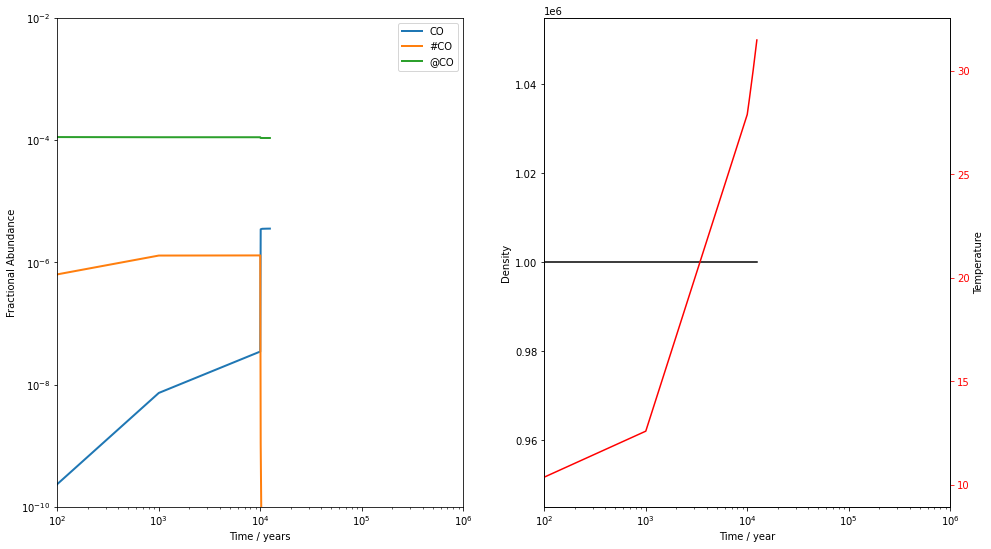

In [19]:
species=["CO","#CO","@CO"]#["CO","H2O","CH3OH","#CO","#H2O","#CH3OH","@H2O","@CO","@CH3OH"]

fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.analysis.plot_species(ax,phase2_df,species)
settings=ax.set(yscale="log",xlim=(1e2,1e6),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(phase2_df["Time"],phase2_df["Density"],color="black")
ax2.set(xscale="log")
ax3=ax2.twinx()
ax3.plot(phase2_df["Time"],phase2_df["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1e2,1e6))
ax3.tick_params(axis='y', colors='red')

## Shocks

Essentially the same process should be followed for shocks. Let's run a C-type and J-type shock through a gas of density $10^4 cm^{-3}$. Again, we first run a simple cloud model to obtain some reasonable starting abundances, then we can run the shocks.

In [10]:
# set a parameter dictionary for phase 1 collapse model

param_dict = {
    "switch": 0,
    "freefall": 1,
    "initialDens": 1e2,
    "initialTemp": 10.0,
    "finalDens": 1e4,
    "finalTime": 6.0e6,
    "outputFile": "../examples/test-output/phase1-full.dat",
    "abundSaveFile": "../examples/test-output/shockstart.dat",
}


In [10]:
#change other bits of input to set up phase 2
param_dict["initialDens"]=1e5
param_dict["finalTime"]=1e6
param_dict["switch"]=0
if "abundSaveFile" in param_dict:
    param_dict.pop("abundSaveFile")
param_dict["abundLoadFile"]="../examples/test-output/shockstart.dat"
param_dict["outputFile"]="../examples/test-output/shock.dat"


success_flag,abunds,dissipation_time=uclchem.cshock(shock_vel=40,param_dict=param_dict)

In [15]:
phase2_df=uclchem.read_output_file("../examples/test-output/shock.dat")
phase2_df=phase2_df[phase2_df["Time"]<20.0*dissipation_time]

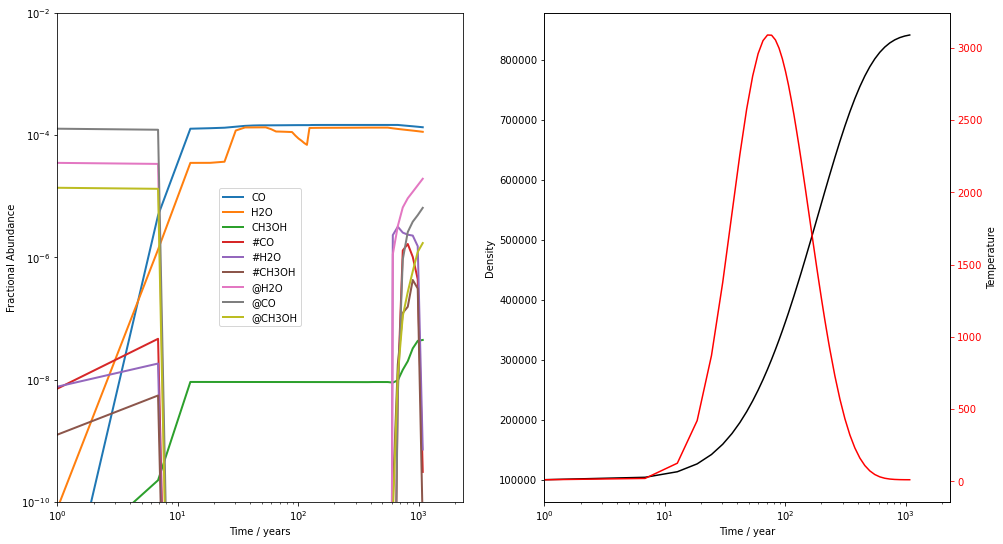

In [18]:
species=["CO","H2O","CH3OH","#CO","#H2O","#CH3OH","@H2O","@CO","@CH3OH"]

fig,[ax,ax2]=plt.subplots(1,2,figsize=(16,9))
ax=uclchem.plot_species(ax,phase2_df,species)
settings=ax.set(yscale="log",xlim=(1,20*dissipation_time),ylim=(1e-10,1e-2),
            xlabel="Time / years", 
            ylabel="Fractional Abundance",xscale="log")

ax2.plot(phase2_df["Time"],phase2_df["Density"],color="black")
ax2.set(xscale="log")
ax3=ax2.twinx()
ax3.plot(phase2_df["Time"],phase2_df["gasTemp"],color="red")
ax2.set(xlabel="Time / year",ylabel="Density")
ax3.set(ylabel="Temperature",facecolor="red",xlim=(1,20*dissipation_time))
ax3.tick_params(axis='y', colors='red')

In [2]:
#change other bits of input to set up phase 2
#set a parameter dictionary for phase 1 collapse model

param_dict = {"switch": 0, "collapse": 1, "writeStep": 1,
                "initialDens": 1e2, "initialTemp":10.0,
               "finalDens":1e3, "finalTime":6.0e6,
               "outputFile":"../examples/test-output/phase1-full.dat",
               "abundSaveFile":"../examples/test-output/shockstart.dat"}
#result=uclchem.cloud(param_dict)
#print(result)
param_dict["initialDens"]=1e3
param_dict["finalTime"]=1e6
param_dict["switch"]=0
shock_vel=10.0
if "abundSaveFile" in param_dict:
    param_dict.pop("abundSaveFile")
param_dict["abundLoadFile"]="../examples/test-output/shockstart.dat"
param_dict["outputFile"]="../examples/test-output/shock.dat"


result=uclchem.jshock(shock_vel=shock_vel,param_dict=param_dict)


{'switch': 0, 'collapse': 1, 'writeStep': 1, 'initialDens': 1000.0, 'initialTemp': 10.0, 'finalDens': 1000.0, 'finalTime': 1000000.0, 'outputFile': '../examples/test-output/shock.dat', 'abundLoadFile': '../examples/test-output/shockstart.dat'}
 Cannot have collapse on during jshock
 setting collapse=0 and continuing


In [ ]:
result

In [3]:
shock_df=uclchem.read_output_file(param_dict["outputFile"])

[None, None]

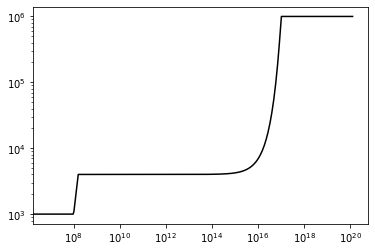

In [4]:
fig,ax=plt.subplots()
ax.plot(shock_df["Time"]*365*24*60*60*40.0e5,shock_df["Density"],color="black")
ax.set(xscale="log",yscale="log")